# Analytics

## Summary

The global model yields around 0.59 MSE on validation / test set.

## Import

In [1]:
import os
import sys
import logging
import multiprocessing
import pandas as pd
import numpy as np
import sqlalchemy
import exchange_calendars as xcals
from dotenv import load_dotenv

# import exchange_calendars as xcals
from datetime import datetime, timedelta

# import pytz
# import pandas as pd
# from IPython.display import display, HTML
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import insert, TEXT
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Init

In [2]:
load_dotenv()  # take environment variables from .env.

module_path = os.getenv("LOCAL_AKSHARE_DEV_MODULE")
if module_path is not None and module_path not in sys.path:
    sys.path.insert(0, module_path)
import akshare as ak  # noqa: E402

print(ak.__version__)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create an engine instance
alchemyEngine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_recycle=3600,
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

file_handler = logging.FileHandler("etl.log")
console_handler = logging.StreamHandler()

# Step 4: Create a formatter
formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")

# Step 5: Attach the formatter to the handlers
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 6: Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

xshg = xcals.get_calendar("XSHG")

1.12.93


## Helper Functions

In [3]:
def predict(
    symbol, y_column, country=None, fourier_terms="auto", show_uncertainty=False
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    return predict_generic(
        "fund_etf_daily_em", symbol, y_column, country, fourier_terms, show_uncertainty
    )


def predict_generic(
    table,
    symbol,
    y_column,
    country=None,
    fourier_terms="auto",
    show_uncertainty=False,
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    query = f"SELECT * FROM {table} where symbol = '{symbol}' order by date"
    df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

    df = df.rename(
        columns={
            "date": "ds",
            y_column: "y",
        }
    )

    m = NeuralProphet(
        mcmc_samples=300 if show_uncertainty else 0,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=fourier_terms,
    )  # Prophet object can only be fit once. Instantiate a new object.
    if country is not None:
        m.add_country_holidays(country_name=country)
    m.fit(df)

    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    return (m, df, forecast)

## Trial 1 - Global Model

#### load data from table

In [23]:
# load main TS
symbol = "930955"
query = f"""
    SELECT '{symbol}' ID, date DS, open, close, high, low, volume, amount, change_rate y 
    FROM index_daily_em_view 
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

,id,ds,open,close,high,low,volume,amount,y
0,930955,2020-02-10,8164.40,8265.17,8269.77,8136.36,339588.0,2.830927e+10,0.00
1,930955,2020-02-11,8270.06,8301.47,8345.08,8243.03,353603.0,2.742411e+10,0.44
2,930955,2020-02-12,8294.21,8336.28,8336.28,8266.64,270681.0,2.081825e+10,0.42
3,930955,2020-02-13,8329.26,8276.91,8368.77,8275.46,294042.0,2.459196e+10,-0.71
4,930955,2020-02-14,8264.24,8312.55,8321.35,8264.24,278215.0,2.315006e+10,0.43


In [ ]:
df.describe()

#### load covariate TS

In [24]:
# 159981 能源化工ETF
# 518880 黄金ETF
# 159985 豆粕ETF
cov_symbol_list = "('518880', '159981', '159985', '511220')"
query = f"""
    SELECT symbol ID, date DS, open, close, high, low, volume, turnover amount, change_rate y 
    FROM fund_etf_daily_em 
    where symbol in {cov_symbol_list}
    order by ID, DS asc
"""
cov_df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

In [25]:
# concat to the main TS
df = pd.concat((df, cov_df))

In [32]:
df = df.rename(columns={
    "id":"ID",
})

In [33]:
df

,ID,ds,open,close,high,low,volume,amount,y
0,930955,2020-02-10,8164.400,8265.170,8269.770,8136.360,339588.0,2.830927e+10,0.00
1,930955,2020-02-11,8270.060,8301.470,8345.080,8243.030,353603.0,2.742411e+10,0.44
2,930955,2020-02-12,8294.210,8336.280,8336.280,8266.640,270681.0,2.081825e+10,0.42
3,930955,2020-02-13,8329.260,8276.910,8368.770,8275.460,294042.0,2.459196e+10,-0.71
4,930955,2020-02-14,8264.240,8312.550,8321.350,8264.240,278215.0,2.315006e+10,0.43
...,...,...,...,...,...,...,...,...,...
6889,518880,2024-03-18,4.879,4.860,4.879,4.857,970311.0,4.720004e+08,-0.80
6890,518880,2024-03-19,4.877,4.870,4.884,4.863,722725.0,3.523246e+08,0.21
6891,518880,2024-03-20,4.878,4.880,4.882,4.877,487890.0,2.380590e+08,0.21
6892,518880,2024-03-21,4.970,4.978,4.979,4.961,1003699.0,4.987390e+08,2.01


In [34]:
# check if any duplicated values (same 'ds' value for each 'id')
df[df.duplicated(["ds", "ID"], keep=False)]

,ID,ds,open,close,high,low,volume,amount,y


In [35]:
df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any()

False

#### transform DF to Prophet schema

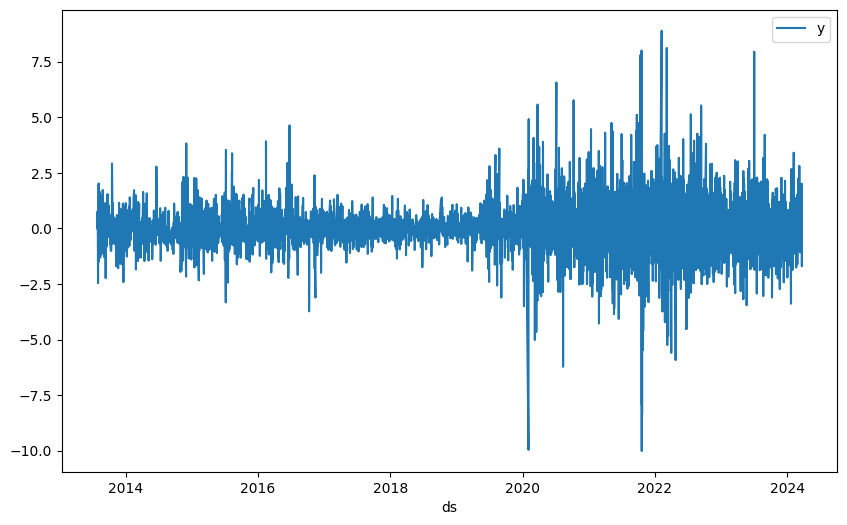

In [26]:
fig = df.plot(x="ds", y=["y"], figsize=(10, 6))

In [ ]:
# df = df.rename(
#     columns={
#         "date": "ds",
#         "china_yield_spread_10y_2y": "y",
#         "us_yield_spread_10y_2y": "cov",
#     }
# )
# df = df[["ds", "y", "cov"]]
# fig = df.plot(x="ds", y=["y", "cov"], figsize=(10, 6))
# df = df[["ds", "y"]]
fig = df.plot(x="ds", y=["open", "close", "high", "low"], figsize=(10, 6))

In [ ]:
fig = df.plot(x="ds", y=["amount"], figsize=(10, 6))

In [ ]:
fig = df.plot(x="ds", y=["volume"], figsize=(10, 6))

#### fitting

In [36]:
confidence_level = 0.9

boundaries = round((1 - confidence_level) / 2, 2)
# NeuralProphet only accepts quantiles value in between 0 and 1
quantiles = [boundaries, confidence_level + boundaries]

m = NeuralProphet(
    quantiles=quantiles,
    # Disable change trendpoints
    n_changepoints=50,
    season_global_local="local",
    # Smaller values (~0.1-1) allow the model to fit larger seasonal fluctuations, 
    # larger values (~1-100) dampen the seasonality. default: None, no regularization
    seasonality_reg=0.7,
    yearly_seasonality=11,  # fourier terms, default 10
    yearly_seasonality_glocal_mode="local",  # global / local / glocal
    # Disable seasonality components
    weekly_seasonality=False,
    daily_seasonality=False,
    # array of hidden layer dimensions of the AR-Net. Specifies number of hidden layers (number of entries) and layer dimension (list entry)
    ar_layers=[
        64,
        64,
        64,
        64,
        64,
    ],
    # array of hidden layer dimensions of the Covar-Net.
    # Specifies number of hidden layers (number of entries) and layer dimension (list entry).
    lagged_reg_layers=[
        64,
        64,
        64,
        64,
        64,
    ],
    # Previous time series steps to include in auto-regression. Aka AR-order
    n_lags=30,
    # Number of steps ahead of prediction time step to forecast.
    # n_forecasts=60,
    # how much sparsity to induce in the AR-coefficients.
    # Large values (~1-100) will limit the number of nonzero coefficients dramatically.
    # Small values (~0.001-1.0) will allow more non-zero coefficients. default: 0 no regularization of coefficients.
    ar_reg=0.05,
    trend_global_local="local",
    # whether to automatically impute missing dates/values
    # imputation follows a linear method up to 20 missing values, more are filled with trend.
    impute_missing=True,
    # Type of normalization to apply to the time series.
    # - (default) soft scales the minimum value to 0.0 and the 95th quantile to 1.0
    # - standardize zero-centers and divides by the standard deviation
    # normalize="standardize",
)

m.add_lagged_regressor("open", n_lags="auto")
m.add_lagged_regressor("high", n_lags="auto")
m.add_lagged_regressor("low", n_lags="auto")
m.add_lagged_regressor("close", n_lags="auto")
m.add_lagged_regressor("volume", n_lags="auto")
m.add_lagged_regressor("amount", n_lags="auto")
# m = m.add_country_holidays("CN")

train_df, test_df = m.split_df(df, freq="D", valid_p=1.0 / 16)
train_df, cal_df = m.split_df(train_df, freq="D", valid_p=1.0 / 16)

train_df.shape, cal_df.shape, test_df.shape

((9540, 9), (1280, 9), (1355, 9))

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    freq="D",
    progress=None,
    # epochs=500
)
metrics

#### predicting

In [39]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

In [50]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast[forecast["ID"] == symbol]["yhat1"]
    - forecast[forecast["ID"] == symbol]["y"]
).mean()
std_diff = (
    forecast[forecast["ID"] == symbol]["yhat1"]
    - forecast[forecast["ID"] == symbol]["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: -0.016423542718052134, Standard deviation of difference: 0.5961128583709062


#### plotting

In [40]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
# m.highlight_nth_step_ahead_of_each_forecast(None)
m.plot(forecast, df_name=symbol)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [41]:
m.plot_components(
    forecast,
    df_name=symbol,
    components=[
        "trend",
        "seasonality",
        "autoregression",
        "uncertainty",
        #   "lagged_regressors"
    ],
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [42]:
m.plot_parameters(
    df_name=symbol,
    components=[
        "trend",
        "trend_rate_change",
        "seasonality",
        "autoregression",
        # "lagged_regressors"
    ]
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

#### Conformal Predict

In [43]:
method = "cqr"  # naive / cqr. ref: https://neuralprophet.com/how-to-guides/feature-guides/uncertainty_quantification.html
alpha = 1 - confidence_level

cfm_forecast = m.conformal_predict(
    df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    show_all_PI=True,
)

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

Predicting: 147it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/uncertainty.py:110: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [44]:
cfm_forecast

,ds,y,ID,yhat1,yhat1 95.0% - qhat1,yhat1 5.0% + qhat1,ar1,lagged_regressor_open1,lagged_regressor_high1,lagged_regressor_low1,lagged_regressor_close1,lagged_regressor_volume1,lagged_regressor_amount1,trend,season_yearly,yhat1 5.0%,yhat1 95.0%
0,2020-01-17,0.000000,159981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-18,0.506667,159981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-19,1.013333,159981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-20,1.520000,159981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-21,-0.900000,159981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,2024-03-18,0.200000,930955,-0.388915,-2.803859,1.954297,-0.837930,-0.216079,0.293776,0.325329,-0.066795,-0.055205,-0.513488,-0.239305,0.920781,-0.526536,-0.323026
11871,2024-03-19,-0.650000,930955,-0.384476,-2.793013,1.892847,-0.916689,-0.151054,0.205370,0.227428,-0.046694,-0.038592,-0.358963,-0.239294,0.934013,-0.515690,-0.384476
11872,2024-03-20,0.230000,930955,0.636282,-1.742203,2.953104,0.227683,-0.266143,0.361842,0.400706,-0.082270,-0.067995,-0.632459,-0.239283,0.934202,0.535120,0.675781
11873,2024-03-21,0.020000,930955,-2.234751,-4.590051,0.042572,-2.726037,-0.177975,0.241971,0.267960,-0.055016,-0.045470,-0.422938,-0.239271,0.922025,-2.312728,-2.234751


In [49]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (cfm_forecast[cfm_forecast['ID'] == symbol]['yhat1'] - cfm_forecast[cfm_forecast['ID'] == symbol]['y']).mean()
std_diff = (cfm_forecast[cfm_forecast['ID'] == symbol]['yhat1'] - cfm_forecast[cfm_forecast['ID'] == symbol]['y']).std()
print(f'Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}')

Mean difference: -0.016423542394333763, Standard deviation of difference: 0.5961128587768642


In [ ]:
# naive_qhat =   naive_forecast.iloc[-1]["yhat1"] - naive_forecast.iloc[-1]["yhat1 - qhat1"]
# naive_qhat

In [46]:
m.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cfm_forecast,
    df_name=symbol,
    plotting_backend="plotly"
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [47]:
m.plot_parameters(
    df_name=symbol,
    components=[
        "trend",
        "trend_rate_change",
        "seasonality",
        "autoregression",
        # "lagged_regressors"
    ],
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur